# Using XGBoosting with Preprocessed Features

## Importing data and creating train, val, test splits

### Importing preprocessed data

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

#Reading Raw X_train
X_train = pd.read_csv('/Users/niki/code/Niki827/watt_squad/raw_data/train.csv')
X_test = pd.read_csv('/Users/niki/code/Niki827/watt_squad/raw_data/test.csv')

#Log columns
f_logs = [
    'precip_1h:mm',
    'prob_precip_1h:p',
    'clear_sky_rad:W',
    'clear_sky_energy_1h:J',
    'diffuse_rad:W',
    'diffuse_rad_1h:Wh',
    'direct_rad:W',
    'direct_rad_1h:Wh',
    'global_rad:W',
    'global_rad_1h:Wh',
    'wind_speed_2m:ms',
    'wind_speed_10m:ms',
    'wind_speed_50m:ms',
    'wind_speed_100m:ms'
]

epsilon = 1e-5

for f in f_logs:
    X_train[f] = np.log(X_train[f] + epsilon)
    X_test[f] = np.log(X_test[f] + epsilon)

# Converting time to datetime
# We might have done that before already
X_train['time']= pd.to_datetime(X_train['time'])
X_test['time']= pd.to_datetime(X_test['time'])

#the following two steps creates new columns to get the input for the sine & cosine columns
#creating columns indicating the hour and the month
X_train['hour'] = X_train['time'].dt.hour
X_train['month'] = X_train['time'].dt.month

X_test['hour'] = X_test['time'].dt.hour
X_test['month'] = X_test['time'].dt.month

#creating column indicating the season
def assign_season(month):
    if month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    elif month in [9, 10, 11]:
        return 3  # Fall
    else:  # December, January, February
        return 4  # Winter

# X_train
X_train['season'] = X_train['month'].apply(assign_season)

X_train['hour_sine'] = np.sin(2 * np.pi * X_train['hour'] / 24)
X_train['hour_cosine'] = np.cos(2 * np.pi * X_train['hour'] / 24)

X_train['month_sine'] = np.sin(2 * np.pi * X_train['month'] / 12)
X_train['month_cosine'] = np.cos(2 * np.pi * X_train['month'] / 12)

X_train['season_sine'] = np.sin(2 * np.pi * X_train['season'] / 4)
X_train['season_cosine'] = np.cos(2 * np.pi * X_train['season'] / 4)

X_train = X_train.drop(columns = ['hour', 'month', 'season'])

# X_test
X_test['season'] = X_test['month'].apply(assign_season)

X_test['hour_sine'] = np.sin(2 * np.pi * X_test['hour'] / 24)
X_test['hour_cosine'] = np.cos(2 * np.pi * X_test['hour'] / 24)

X_test['month_sine'] = np.sin(2 * np.pi * X_test['month'] / 12)
X_test['month_cosine'] = np.cos(2 * np.pi * X_test['month'] / 12)

X_test['season_sine'] = np.sin(2 * np.pi * X_test['season'] / 4)
X_test['season_cosine'] = np.cos(2 * np.pi * X_test['season'] / 4)

X_test = X_test.drop(columns = ['hour', 'month', 'season'])

# Cyclic features
cyclical_features = ['sun_azimuth:d', 'wind_dir_2m:d', 'wind_dir_10m:d', 'wind_dir_50m:d', 'wind_dir_100m:d']
degrees = 360

for cyclical_feature in cyclical_features:
    sin_column_name = f'sin_{cyclical_feature}'
    cos_column_name = f'cos_{cyclical_feature}'
    X_train[sin_column_name] = np.sin(2 * np.pi * X_train[cyclical_feature]/2)
    X_train[cos_column_name] = np.cos(2 * np.pi * X_train[cyclical_feature]/degrees)
    X_test[sin_column_name] = np.sin(2 * np.pi * X_test[cyclical_feature]/2)
    X_test[cos_column_name] = np.cos(2 * np.pi * X_test[cyclical_feature]/degrees)

X_train = X_train.drop(columns=cyclical_features)
X_test = X_test.drop(columns=cyclical_features)

# targets = ['pv_production', 'wind_production', 'consumption']
f_minmax = [
    'hour_sine',
    'hour_cosine',
    'month_sine',
    'month_cosine',
    'season_sine',
    'season_cosine',
    'precip_1h:mm',
    'prob_precip_1h:p',
    'clear_sky_rad:W',
    'clear_sky_energy_1h:J',
    'diffuse_rad:W',
    'diffuse_rad_1h:Wh',
    'direct_rad:W',
    'direct_rad_1h:Wh',
    'global_rad:W',
    'global_rad_1h:Wh',
    'sunshine_duration_1h:min',
    'low_cloud_cover:p',
    'medium_cloud_cover:p',
    'high_cloud_cover:p',
    'total_cloud_cover:p',
    'effective_cloud_cover:p',
    'sin_sun_azimuth:d',
    'cos_sun_azimuth:d',
    'sin_wind_dir_2m:d',
    'cos_wind_dir_2m:d',
    'sin_wind_dir_10m:d',
    'cos_wind_dir_10m:d',
    'sin_wind_dir_50m:d',
    'cos_wind_dir_50m:d',
    'sin_wind_dir_100m:d',
    'cos_wind_dir_100m:d',
    'relative_humidity_2m:p',
    'relative_humidity_10m:p',
    'relative_humidity_50m:p',
    'relative_humidity_100m:p',
    'dew_point_2m:C',
    'dew_point_10m:C',
    'dew_point_50m:C',
    'dew_point_100m:C',
    'temp'
]
f_standard = ['sun_elevation:d']
f_robust = [
    't_10m:C',
    't_50m:C',
    't_100m:C',
    'wind_speed_2m:ms',
    'wind_speed_10m:ms',
    'wind_speed_50m:ms',
    'wind_speed_100m:ms'
]

f_ohe = ['precip_type:idx']

# other = ['spot_market_price']

# target
y = X_train[['pv_production', 'wind_production', 'consumption']]
# features
X_train = X_train.drop(columns=['time', 'pv_production', 'wind_production', 'consumption', 'spot_market_price'])
X_test = X_test.drop(columns=['time', 'pv_production', 'wind_production', 'consumption', 'spot_market_price'])

# Preprocessing Pipeline
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
cat_transformer = OneHotEncoder()
robust_scaler = RobustScaler()

preproc_basic = make_column_transformer(
    (minmax_scaler, f_minmax ),
    (standard_scaler, f_standard),
    (robust_scaler, f_robust),
    (cat_transformer, f_ohe),
    remainder='passthrough'
)
# Train X
X_train_transformed = preproc_basic.fit_transform(X_train)

# Adding Column names
X_train_transformed = pd.DataFrame(
    X_train_transformed,
    columns=preproc_basic.get_feature_names_out()
)
# Test x
X_test_transformed = preproc_basic.transform(X_test)
# Adding Column names
X_test_transformed = pd.DataFrame(
    X_test_transformed,
    columns=preproc_basic.get_feature_names_out()
)

### Creating y_train and y_test for solar production

In [2]:
# creating y_train dataframe
y_train = y.copy()['wind_production']

# Importing y_test
y_test = pd.read_csv('/Users/niki/code/Niki827/watt_squad/raw_data/test.csv')
y_test = y_test['wind_production']

### Creating X_val and y_val for solar production

In [3]:
from sklearn.model_selection import train_test_split

# Use the same function above for the validation set
X_train_transformed, X_val, y_train, y_val = train_test_split(
    X_train_transformed, y_train, test_size = 0.1, random_state = 42  # val = 10%
)

## Building an XGB Regressor and plotting its predictions vs. actual

In [5]:
# install Le Wagon Version of XGBoost
#pip install xgboost==1.6.2

### Final version of the model included in the model.py script

In [4]:
from xgboost import XGBRegressor

# Initialize the model with the best parameters from grid search
xgb_reg = XGBRegressor(
    max_depth=7,                # Optimal value found
    n_estimators=300,           # Optimal value found
    learning_rate=0.05,         # Optimal value found
    reg_alpha=0.05,             # Optimal value found
    reg_lambda=20,              # Optimal value found
    subsample=0.8,              # Optimal value found
    colsample_bytree=0.8,       # Optimal value found
    objective='reg:squarederror',
    eval_metric="mae",
    random_state=42             # Ensuring reproducibility
)

# Fit the model on the training data
xgb_reg.fit(
    X_train_transformed, 
    y_train,
    eval_set=[(X_train_transformed, y_train), (X_val, y_val)],
    early_stopping_rounds=5     # Retain early stopping
)

# Make predictions
y_pred = xgb_reg.predict(X_test_transformed)

/Users/niki/.pyenv/versions/3.10.6/envs/watt_squad/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:20.97452	validation_1-mae:21.54546
[1]	validation_0-mae:20.32871	validation_1-mae:20.85245
[2]	validation_0-mae:19.74000	validation_1-mae:20.23855
[3]	validation_0-mae:19.16486	validation_1-mae:19.64837
[4]	validation_0-mae:18.70193	validation_1-mae:19.20352
[5]	validation_0-mae:18.20677	validation_1-mae:18.70209
[6]	validation_0-mae:17.75247	validation_1-mae:18.24444
[7]	validation_0-mae:17.32320	validation_1-mae:17.82544
[8]	validation_0-mae:16.91647	validation_1-mae:17.43986
[9]	validation_0-mae:16.55877	validation_1-mae:17.09041
[10]	validation_0-mae:16.21704	validation_1-mae:16.74487
[11]	validation_0-mae:15.88948	validation_1-mae:16.42599
[12]	validation_0-mae:15.58948	validation_1-mae:16.13138
[13]	validation_0-mae:15.30659	validation_1-mae:15.85121
[14]	validation_0-mae:15.04358	validation_1-mae:15.61718
[15]	validation_0-mae:14.80071	validation_1-mae:15.39004
[16]	validation_0-mae:14.56787	validation_1-mae:15.18280
[17]	validation_0-mae:14.35873	validation

## Plotting PV (!) best model forecasts vs. actual pv production

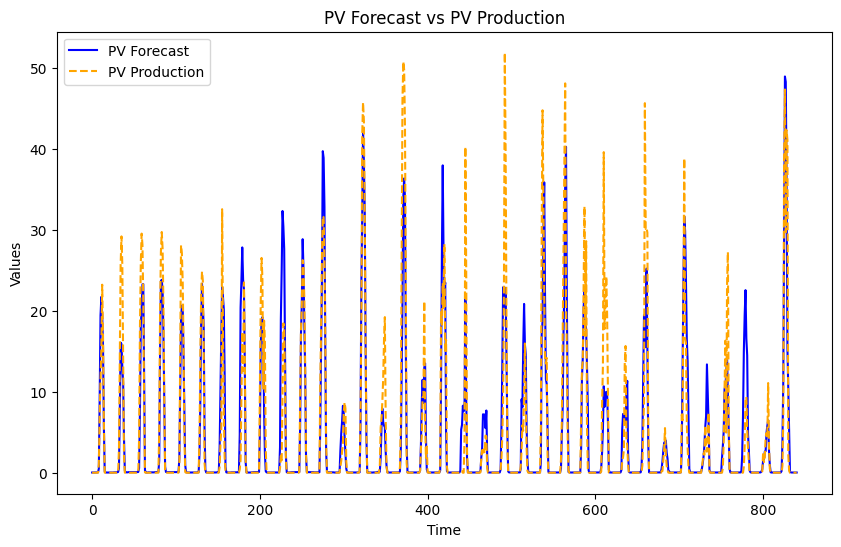

In [47]:
predictions_df = pd.read_csv("~/code/Niki827/watt_squad/raw_data/test.csv")
predictions_df = predictions_df[['time']]
predictions_df['pv_forecast'] = y_pred

y_plot = pd.read_csv('~/code/Niki827/watt_squad/raw_data/test.csv')


import matplotlib.pyplot as plt

# Assuming predictions_df and y_plot are your DataFrames
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the 'pv_forecast' column
plt.plot(predictions_df['pv_forecast'], label='PV Forecast', color='blue', linestyle='-')

# Plot the 'pv_production' column
plt.plot(y_plot['pv_production'], label='PV Production', color='orange', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('PV Forecast vs PV Production')
plt.legend()

# Display the plot
plt.show()

## Evaluating predictions of the model on test data

In [5]:
baseline_mae = ((abs(y_train-y_train.mean())).mean())
baseline_mae

26.042127820606378

In [6]:
model_mae = ((abs(y_test-y_pred)).mean())
model_mae

20.754711344890055

In [7]:
y_test.describe()

count    841.000000
mean      20.086468
std       27.797933
min       -0.850000
25%       -0.260000
50%        9.440000
75%       30.890000
max      195.570000
Name: wind_production, dtype: float64

## Feature importance and correlation matrix

### Calculating feature importance

In [18]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train_transformed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
import pandas as pd

importance = best_model.feature_importances_
feature_names = X_train_transformed.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

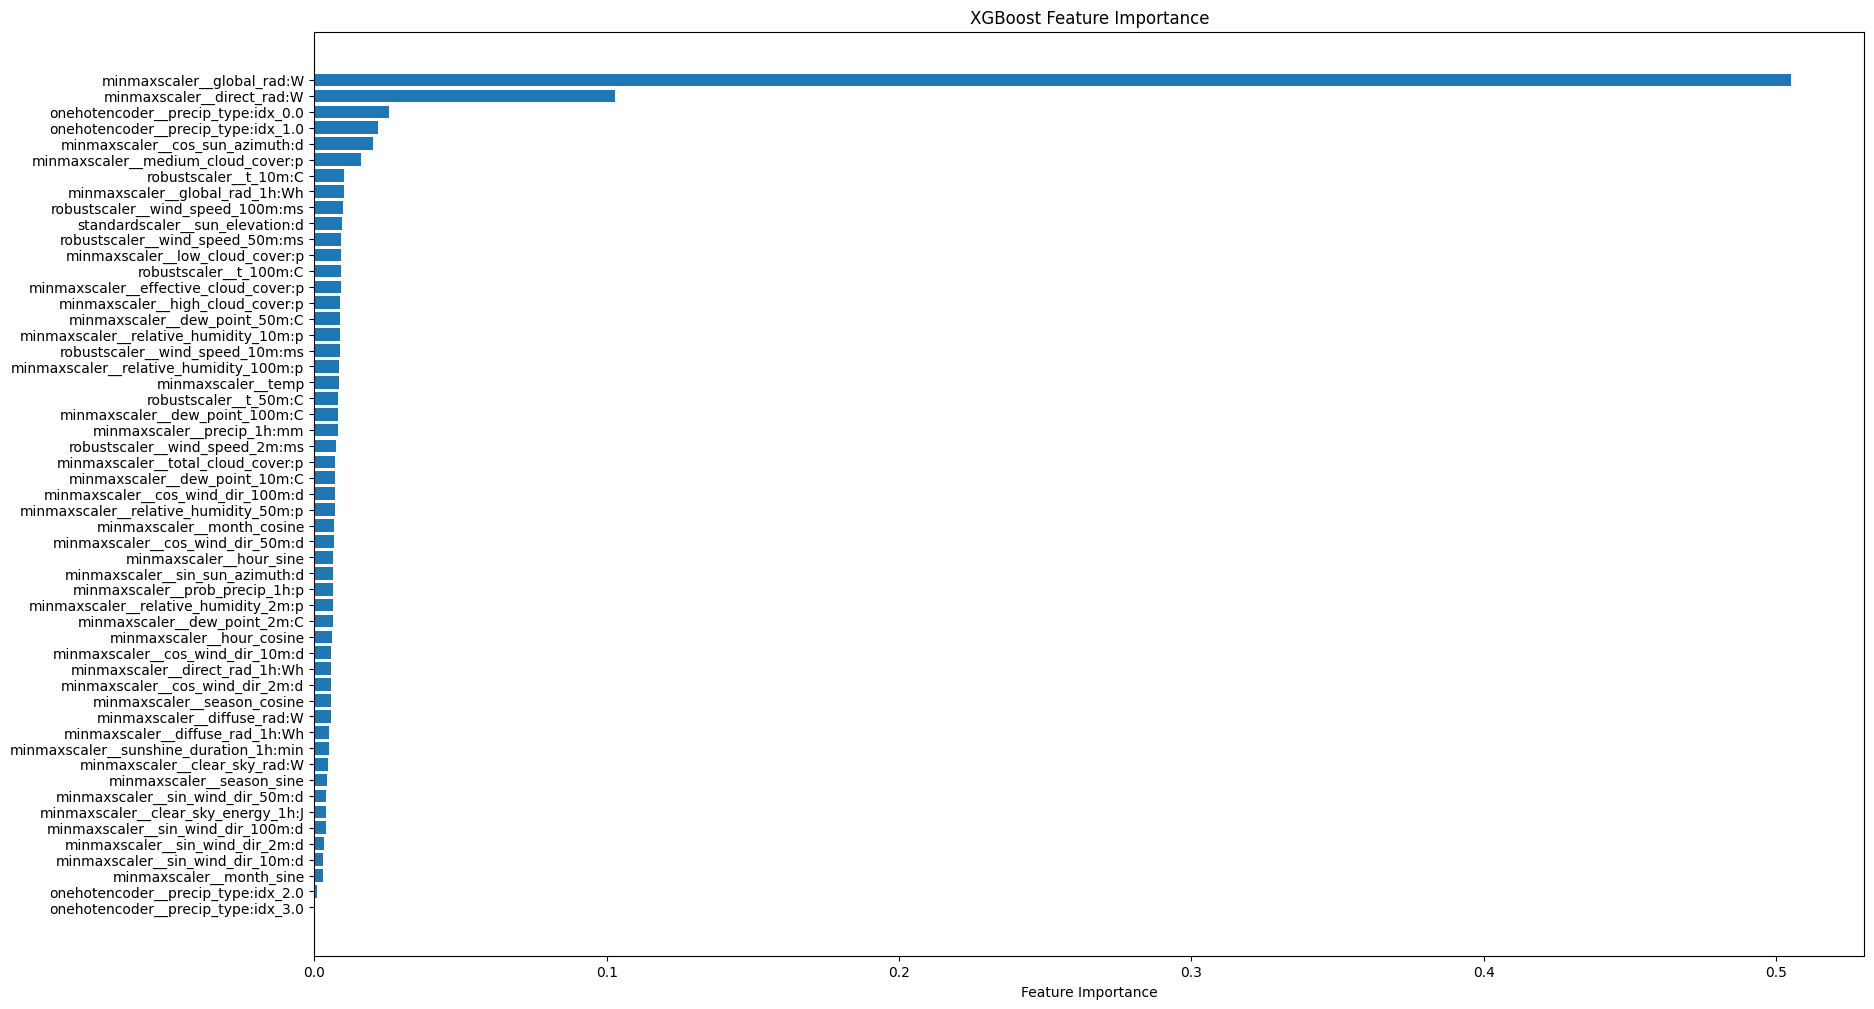

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

In [39]:
importance_df

,Feature,Importance
14,minmaxscaler__global_rad:W,0.504930
12,minmaxscaler__direct_rad:W,0.102730
49,onehotencoder__precip_type:idx_0.0,0.025672
50,onehotencoder__precip_type:idx_1.0,0.021872
23,minmaxscaler__cos_sun_azimuth:d,0.020055
18,minmaxscaler__medium_cloud_cover:p,0.016008
42,robustscaler__t_10m:C,0.010137
15,minmaxscaler__global_rad_1h:Wh,0.010067
48,robustscaler__wind_speed_100m:ms,0.009916
41,standardscaler__sun_elevation:d,0.009378


### Creating a correlation matrix

In [15]:
correlation_matrix = X_train_transformed.corr()

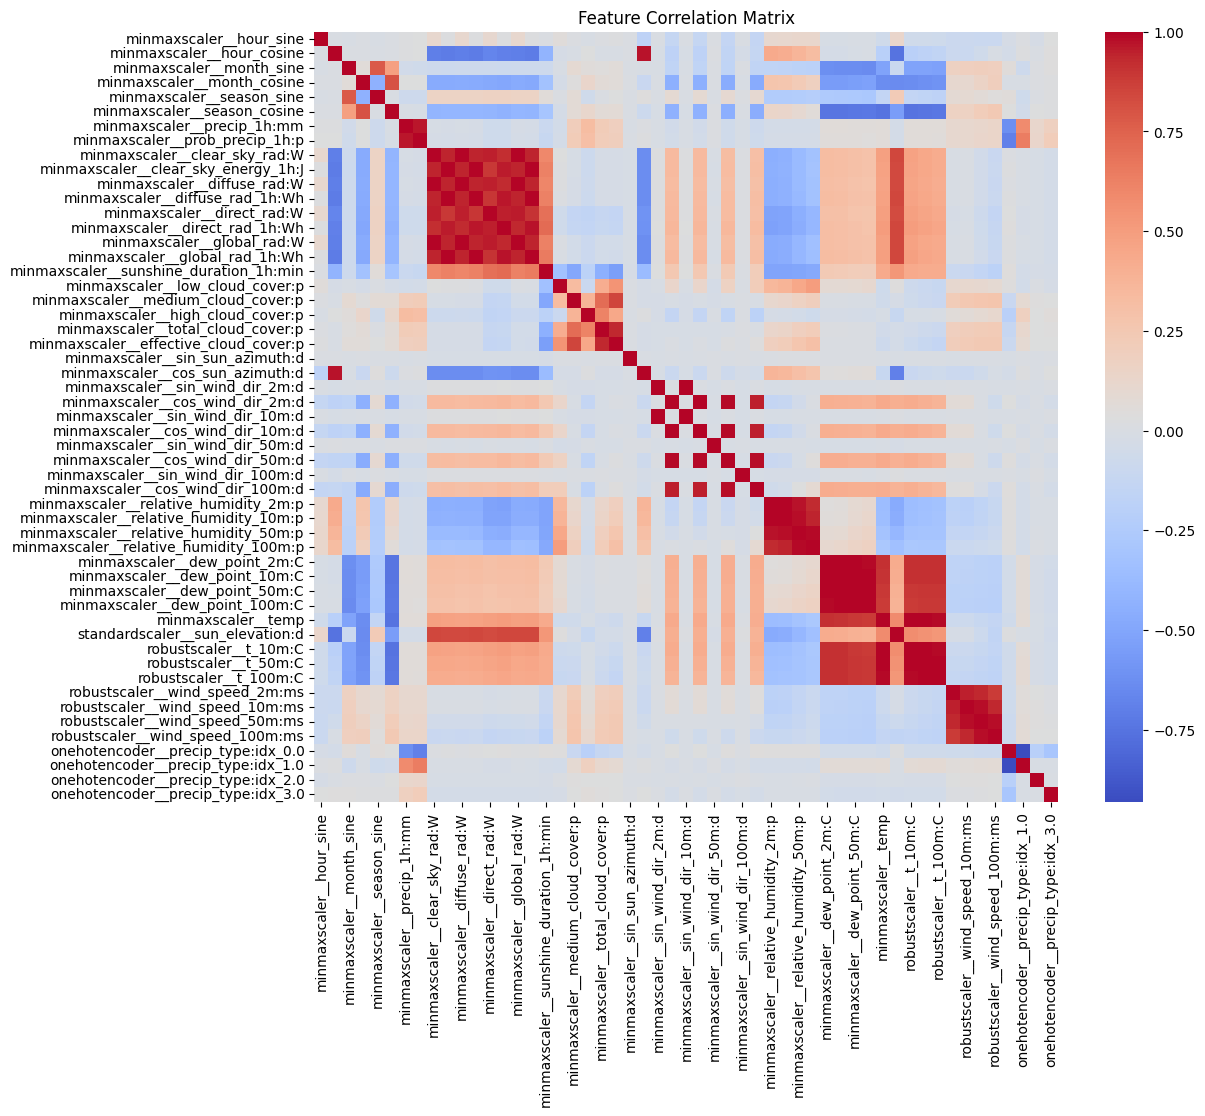

In [16]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [17]:
correlated_features = set()
correlation_threshold = 0.9

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > correlation_threshold:
            correlated_features.add(correlation_matrix.columns[i])

In [27]:
correlation_matrix[['minmaxscaler__global_rad:W']].sort_values(by='minmaxscaler__global_rad:W', ascending=False)

,minmaxscaler__global_rad:W
minmaxscaler__global_rad:W,1.000000
minmaxscaler__diffuse_rad:W,0.998834
minmaxscaler__clear_sky_rad:W,0.998680
minmaxscaler__direct_rad:W,0.958581
minmaxscaler__global_rad_1h:Wh,0.946160
minmaxscaler__diffuse_rad_1h:Wh,0.943009
minmaxscaler__clear_sky_energy_1h:J,0.941516
minmaxscaler__direct_rad_1h:Wh,0.932603
standardscaler__sun_elevation:d,0.843238
minmaxscaler__sunshine_duration_1h:min,0.627275


In [18]:
correlated_features

{'minmaxscaler__clear_sky_energy_1h:J',
 'minmaxscaler__cos_sun_azimuth:d',
 'minmaxscaler__cos_wind_dir_100m:d',
 'minmaxscaler__cos_wind_dir_10m:d',
 'minmaxscaler__cos_wind_dir_50m:d',
 'minmaxscaler__dew_point_100m:C',
 'minmaxscaler__dew_point_10m:C',
 'minmaxscaler__dew_point_50m:C',
 'minmaxscaler__diffuse_rad:W',
 'minmaxscaler__diffuse_rad_1h:Wh',
 'minmaxscaler__direct_rad:W',
 'minmaxscaler__direct_rad_1h:Wh',
 'minmaxscaler__effective_cloud_cover:p',
 'minmaxscaler__global_rad:W',
 'minmaxscaler__global_rad_1h:Wh',
 'minmaxscaler__prob_precip_1h:p',
 'minmaxscaler__relative_humidity_100m:p',
 'minmaxscaler__relative_humidity_10m:p',
 'minmaxscaler__relative_humidity_50m:p',
 'minmaxscaler__sin_wind_dir_10m:d',
 'minmaxscaler__temp',
 'onehotencoder__precip_type:idx_1.0',
 'robustscaler__t_100m:C',
 'robustscaler__t_10m:C',
 'robustscaler__t_50m:C',
 'robustscaler__wind_speed_100m:ms',
 'robustscaler__wind_speed_10m:ms',
 'robustscaler__wind_speed_50m:ms'}

In [51]:
((abs(y_test-y_pred)).mean())

2.7958614410402607

In [49]:
((abs(y_test-y_test.mean())).mean())

6.558063202750535

## Plotting Features

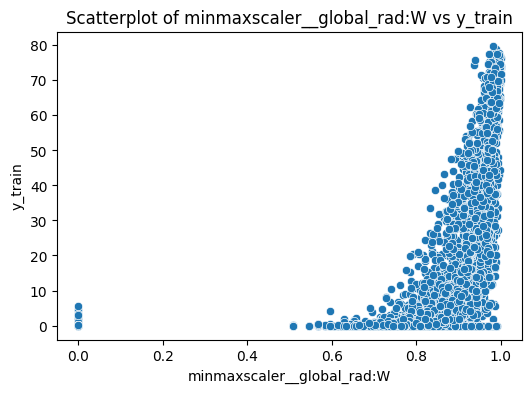

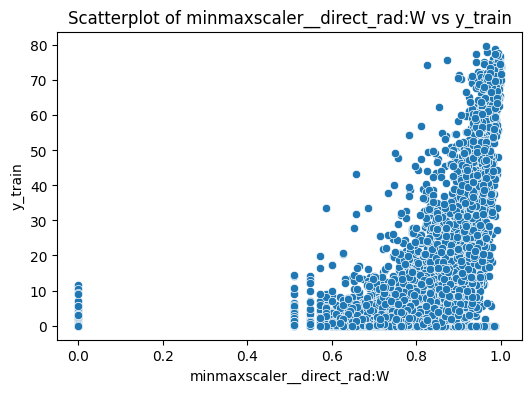

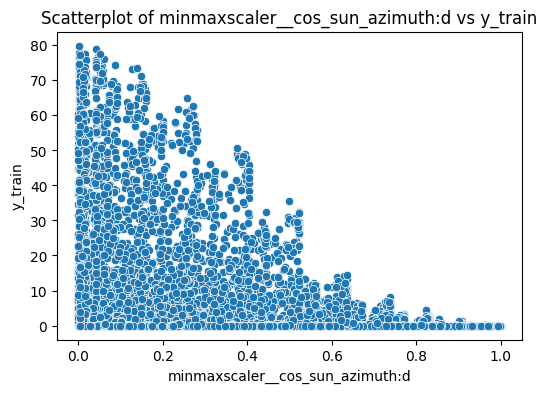

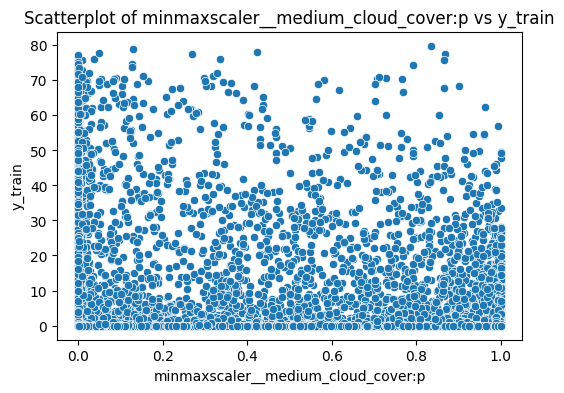

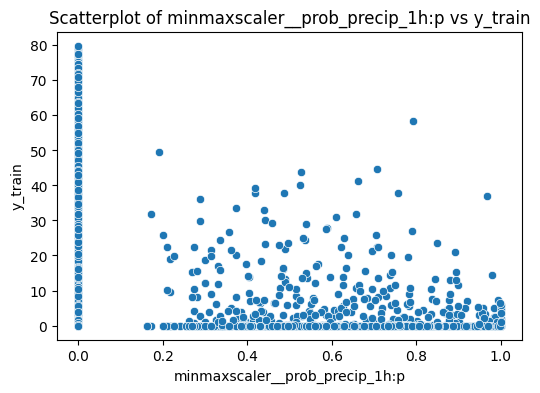

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of the 5 most important features
important_features = [
    'minmaxscaler__global_rad:W',
    'minmaxscaler__direct_rad:W',
    'minmaxscaler__cos_sun_azimuth:d',
    'minmaxscaler__medium_cloud_cover:p',
    'minmaxscaler__prob_precip_1h:p'
]

# Create a scatterplot for each feature
for feature in important_features:
    plt.figure(figsize=(6, 4))  # Set figure size
    sns.scatterplot(x=X_train_transformed[feature], y=y_train)
    plt.title(f"Scatterplot of {feature} vs y_train")
    plt.xlabel(feature)
    plt.ylabel("y_train")
    #plt.xlim(0.4, None)  # Set the lower limit of the x-axis to 0.4
    plt.show()